# ENGR 891: Programming Assignment #2
## Part A: 
### Pre-processing

### Import the packages

In [1]:
import pandas as pd
import numpy as np
import xlrd
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Load the data

In [2]:
# Load the CSV file as a pandas data frame object
df = pd.read_excel('EnergyEfficiency.xlsx', header = 0)
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


### Check if there is a NAN value in data set

In [3]:
# Check if there is a NAN in data set, clean the data if it is True
df.isna().values.any()

False

### Create a separate feature set (Data Matrix X) and target (1D Array y)

In [4]:
# Create a data frame object for the features and another data frame object for the target
X = df.drop(columns=['Y1','Y2'])  # Data frame containing all features excluding the target & id 
y = df['Y1'] # Data frame containing the target 
print(X.astype)
print(y.astype)
X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array

<bound method NDFrame.astype of        X1     X2     X3      X4   X5  X6   X7  X8
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0
..    ...    ...    ...     ...  ...  ..  ...  ..
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5

[768 rows x 8 columns]>
<bound method NDFrame.astype of 0      15.55
1      15.55
2      15.55
3      15.55
4      20.84
       ...  
763    17.88
764    16.54
765    16.44
766    16.48
767    16.64
Name: Y1, Length: 768, dtype: float64>


### Feature Selection: using pearson correlation

In [5]:
# Variable Correlations with the target 
most_correlated = df.corr().abs()['Y1'].sort_values(ascending=False) # the absolute value
# Maintain the top 10 most correlation features with target
most_correlated = most_correlated[:10]
print("Most Correlated Features:\n")
print(most_correlated)

Most Correlated Features:

Y1    1.000000
Y2    0.975862
X5    0.889430
X4    0.861828
X2    0.658120
X1    0.622272
X3    0.455671
X7    0.269842
X8    0.087368
X6    0.002587
Name: Y1, dtype: float64


## Find the optimal features : The most correlated 6 features as below provides the minimum test MSE and max test R^2 variance score

In [6]:
# Case 1 has the most correlated 2,3,4,5,6,7,8 features test accuracy = ....
df_case1 = df[['X5','X4','X2','X1','X3','X7']]

### Convert the above data frame objects to NumPy array

In [7]:
# Convert the above data frame objects to NumPy array
X = np.asarray(df_case1) 

### check the shape of X and y

In [8]:
print("Data Matrix (X) Shape: ", X.shape)
print("Label Array (y) Shape: ", y.shape)

print("\nData Matrix (X) Type: ", X.dtype)
print("Label Array (y) Type: ", y.dtype)

Data Matrix (X) Shape:  (768, 6)
Label Array (y) Shape:  (768,)

Data Matrix (X) Type:  float64
Label Array (y) Type:  float64


### Partition the data in training & test subsets (80% - 20%)

In [9]:
# Partition the dataset into training & test subsets: 80% training & 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Selection: hyperparameter tuning

In [10]:
%%time
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001]}

# Create a GridSearchCV object and perform hyperparameter tuning
sgd = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgd = sgd.best_params_

print("Best Score (negative mean squared error): %f" % sgd.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd)
print("\n")

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1530 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 1880 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2330 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2880 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 3530 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 16.9min finished


Best Score (negative mean squared error): -4.109479
Optimal Hyperparameter Values:  {'poly__degree': 8, 'sgd__alpha': 0.001, 'sgd__eta0': 0.001, 'sgd__l1_ratio': 0.5, 'sgd__max_iter': 500}


CPU times: user 10.4 s, sys: 549 ms, total: 10.9 s
Wall time: 16min 55s


### Model Evaluation: evaluation based on training and test data

In [11]:
# Training data: Make prediction 
y_train_predicted_sgd = sgd.predict(X_train)

print("Train: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_sgd))

# Test data: Make prediction 
y_test_predicted = sgd.predict(X_test)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Train: Mean squared error: 3.52
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.97

Test: Mean squared error: 3.48
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.97


### Create a learning curve (negative MSE vs train/validation data) using the optimal model

No. of Original Features:  6
No. of Augmented Features:  3002


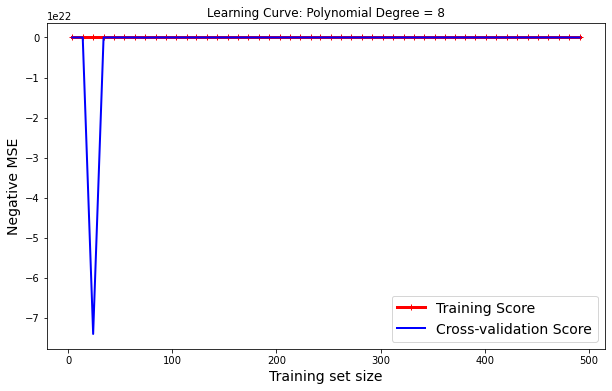

In [12]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = 8


# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])


scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)



train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train_poly_standardized, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
                                                                                                                                                                                                       
                                                        
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve: Polynomial Degree = %d" % poly_degree)
plt.show()

### Q-1) What does the learning curve tell you? Is your model underfitting or overfitting? Does it have high/low bias and high/low variance? Justify your answer.

First, let’s look at the performance on the training data: The performance on the training data is near to perfect as it has close to 0.0 for the entire training set range. 

Then, look at the performance of the model on the validation data. When the model is trained on a few training instances, it is incapable of generalizing properly. However, we used high polynomial degree = **8** so it reduced the validation error close to 0 at the beginning. But it experiences huge validation error when the number of instances increase to roughly **20 to 40**. There might be a brief **overfitting (high variance)** here, hence a huge gap occurred that shows large MSE. Then as the model is shown more training examples, it learns and thus the validation error **quickly** goes down. Finally, the error ends up at ~0.0 for both train and validation data.

The learning curve illustrates that the model is well optimized at polynomial degree of 8 with low bias and low variance. Neither overfitting (high variance) or underfitting (high bias) here. The MSE for both training and validation data is close to 0 which shows a good model overall. 
